## Check visibility (first hit) using custom camera projection

User defined rays pointing to a set of 3D positions allow performing a visibility test.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import NpOptiX

Callback function used to extract hit info. See [rt._geo_id_format](https://plotoptix.rnd.team/npoptix_config.html#plotoptix.NpOptiX._geo_id) for a complete info on data stored in this buffer.

In [2]:
def update_image(rt: NpOptiX) -> None:
    f = rt._geo_id[:,:,0].reshape(rt._height, rt._width)
    f &= 0x3FFFFFFF            # remove the vertex id info (bits 30 and 31)
    invisible = f < 0x3FFFFFFF # something was hit on the way to target point
    rmax = f == 0x3FFFFFFF     # ray did not cross any geometry before reaching rmax range
    f[invisible] = 1
    f[rmax] = 0
    img.set_data(f)
    img.set_clim(vmin=0, vmax=1)
    plt.draw()

Setup the raytracer:

In [3]:
width = 400
height = 300

rt = NpOptiX(on_launch_finished=update_image, width=width, height=height, start_now=False)

# NOTE: no need for multiple passes, set up just 1 pass:
rt.set_param(min_accumulation_step=1, max_accumulation_frames=1)

Read the mesh. Use a simple, flat shading material if the face id is the only interesting thing (so no secondary rays are traced).

In [4]:
from plotoptix.materials import m_flat

rt.setup_material("flat", m_flat)

rt.load_mesh_obj("data/utah-teapot.obj", mat="flat")

Set a wall of target points at Z=-15 (behind the pot from the camera point of view). We're going to shoot rays towards each of these points later. Use 0 on the 4rd coordinate to make the ray max length exactly as the distance from the camera to the target point. Other options are: negative value for infinite ray length, or positive value for user defined range limit for each ray. 

In [5]:
x = np.linspace(-50, 50, width)
y = np.linspace(50, -50, height)
Y, X = np.meshgrid(y, x)

xyzr = np.stack((X, Y, np.full((width, height), -15), np.zeros((width, height)))).T

rt.set_texture_2d("xyzr_tex", xyzr)

Setup camera:

In [6]:
eye = np.array([20.0, 50.0, 100.0])
target = np.array([0.0, 0.0, 0.0])
up = np.array([0.0, 1.0, 0.0])
rt.setup_camera("cam1", cam_type="CustomProjXYZ",
                eye=eye, target=target, up=up,
                textures=["xyzr_tex"])

Show the output image here:

<IPython.core.display.Javascript object>


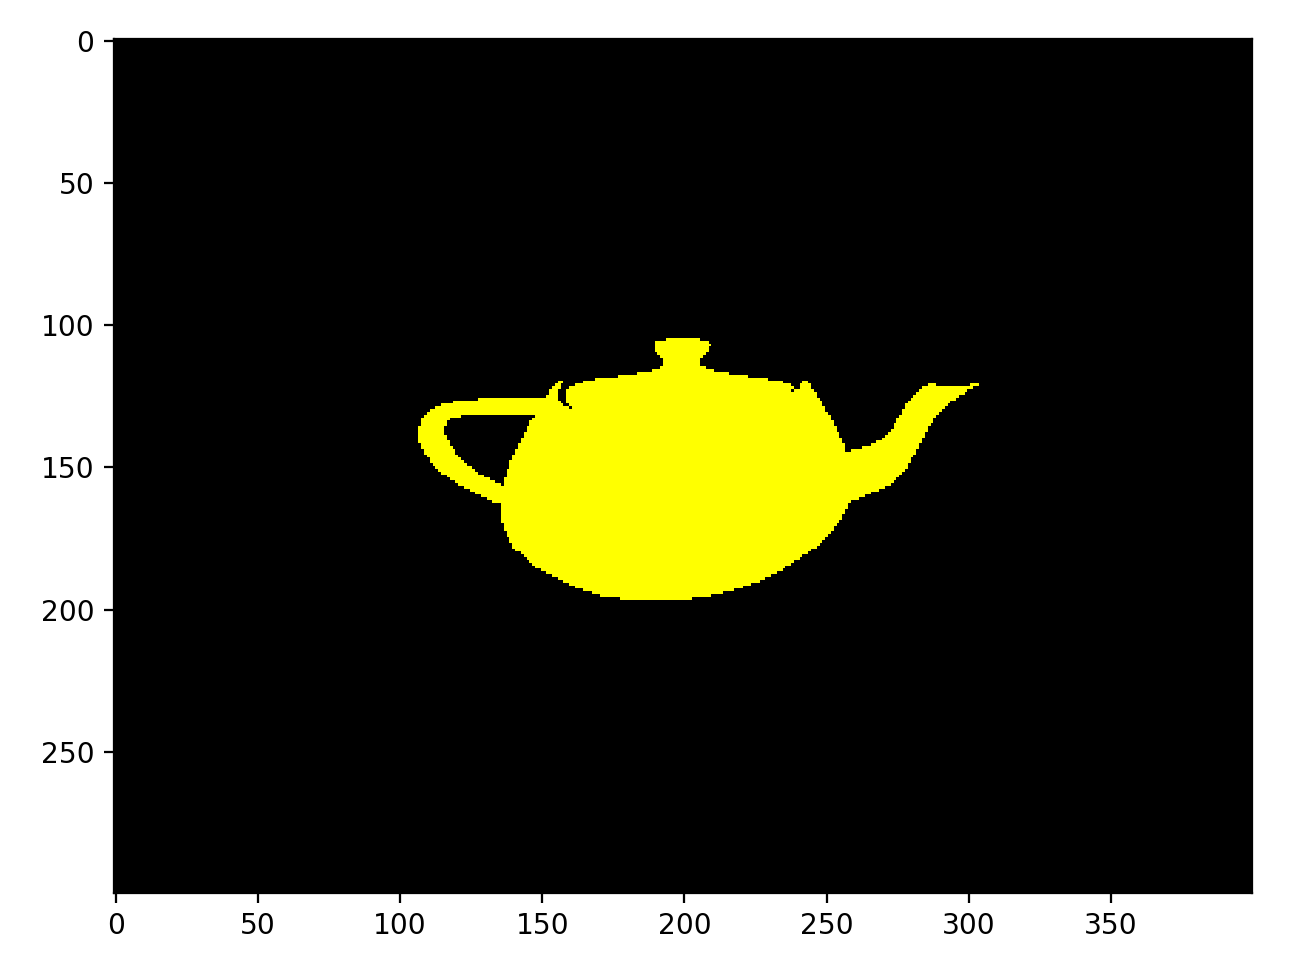

In [7]:
plt.figure(1)
img = plt.imshow(np.zeros((height,width,4)), cmap=plt.get_cmap("gnuplot"))
plt.tight_layout()

Start the ray tracing:

In [8]:
rt.start()

Modify target points: at Z=0 the wall of points should cut the pot in half.

In [9]:
xyzr = np.stack((X, Y, np.full((width, height), 0), np.zeros((width, height)))).T
rt.set_texture_2d("xyzr_tex", xyzr, refresh=True)

Close the ray-tracer.

In [10]:
rt.close()